In [1]:
!pip install rdkit -qqq
!pip install deepchem -qqq
!pip install pyGPGO -qqq

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/MDRinhib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 KB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.8/39.8 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#%load_ext google.colab.data_table
#%unload_ext google.colab.data_table

In [2]:
import pandas as pd
import numpy as np
import rdkit as rd
import tensorflow as tf

from deepchem import deepchem as dc # Needs to me imported weirdly in VS code
from deepchem.models import GraphConvModel

from rdkit import Chem
from rdkit.Chem import Draw

# Uncomment these for production scenarios. (included for reproducibility)
tf.random.set_seed(123)
np.random.seed(123)

# Functions

In [4]:
def unique_ligands(list_of_structures):
    '''
    This function takes a list of structures that was docked in different conformations
    (ie. the same structure occurs several times) and returns a unique list of structures
    '''

    unique_list_prop = []
    unique_list = []

    for x in list_of_structures:
        test = x.GetProp("FDA drugnames") + x.GetProp('s_i_glide_gridfile')
        if test not in unique_list_prop:
            unique_list_prop.append(test)
            unique_list.append(x)
    return unique_list


def data_for_receptor(df, receptor_name, seed=None):
    '''
    This function takes the dataframe created for all receptors and returns
    training, validation and test data that can be used in a GraphConvModel.
    '''
    
    # This code takes the initial df and republish it with data only on one receptor
    df_receptor =  df[[receptor_name, receptor_name+'_mol']]
    # Applying a mask to remove 0 values.
    mask = df_receptor[receptor_name+'_mol'] == 0
    df_receptor = df_receptor.drop(df[mask].index)

    feat = dc.feat.ConvMolFeaturizer()
    x = feat.featurize(df_receptor[receptor_name+'_mol'])
    y = df_receptor[receptor_name].to_numpy()
    ids = df_receptor.index

    # Create dataset for deepchem
    dataset = dc.data.NumpyDataset(X=x, y=y, ids=ids)

    # Transform the output data for regression
    transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset)
    dataset = transformer.transform(dataset)

    # split data
    splitter = dc.splits.RandomSplitter()
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset = dataset,
    frac_train = 0.8,
    frac_valid = 0.1,
    frac_test = 0.1,
    seed=seed,
    )

    return train_dataset, valid_dataset, test_dataset, transformer

# Import data

In [5]:
# Read sdf file with ligands docked to protein
suppl = Chem.SDMolSupplier('All_proteins_total.sdf')

# Put each ligand into list
mols_docked = [x for x in suppl]
print("Total number of FDA drug conformations successfully docked: " + str(len(mols_docked)))

unique_mols_docked = unique_ligands(mols_docked)
print("Number of FDA drugs successfully docked: " + str(len(unique_mols_docked)))

Total number of FDA drug conformations successfully docked: 30861
Number of FDA drugs successfully docked: 10151


In [6]:
unique_mols_docked[5].GetProp('FDA drugnames')

'VASOSTRICT; VASOPRESSIN'

In [7]:
mollist = [] # list of uniquely docked mol objects for featurization

# Creates a list of lists with information on
# Transporter name and site
# Molecule name
# Docking score
for mol in unique_mols_docked:
    mollist.append([mol.GetProp('s_i_glide_gridfile'), mol.GetProp('FDA drugnames'), float(mol.GetProp('r_i_glide_gscore')), mol])

df_initial = pd.DataFrame.from_records(mollist)
#df = df.pivot(index=1, columns=0, values=[2,3])

/usr/local/lib/python3.9/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 2. Change the maxMols value to display more.
  warnings.warn(


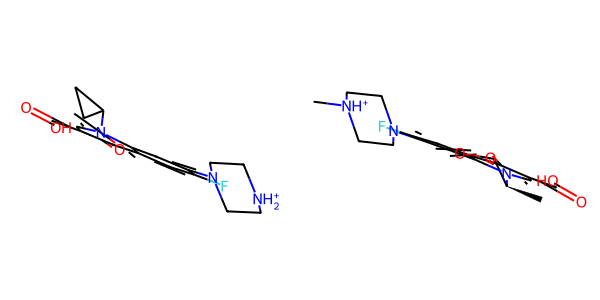

In [8]:
Draw.MolsToGridImage(
    df_initial.iloc[9500:10000,3],
    molsPerRow=2,
    maxMols=2,
    subImgSize=(300, 300),
    )

In [9]:
mollist = [] # list of uniquely docked mol objects for featurization

# Creates a list of lists with information on
# Transporter name and site
# Molecule name
# Docking score
for mol in unique_mols_docked:
    mollist.append([mol.GetProp('s_i_glide_gridfile'), mol.GetProp('FDA drugnames'), float(mol.GetProp('r_i_glide_gscore')), mol])

df = pd.DataFrame.from_records(mollist)
df = df.pivot(index=1, columns=0, values=[2,3])

receptors = []

# The following code fetches receptor names and lists them to be applied as columns in the dataFrame
for rec in df.keys():
    receptors.append(rec[1][11:15])

no_receptors = int(len(receptors)/2)
receptor_scores = []

for i in range(len(receptors)):
    if i >= no_receptors:
        receptors[i] = receptors[i] + "_mol"
    else:
        receptor_scores.append(receptors[i])

df.columns = receptors

# Rounds numbers in the dataFrame to 1 decimal
for rec in receptor_scores:
    df[rec] = pd.to_numeric(df[rec]).round(1)

# Replaces Nan values with 0
df = df.fillna(0)

In [10]:
df

,BCRP,MDR1,MRP1,MRP2,MRP3,MRP4,MRP5,MRP6,MRP7,MRP8,...,MDR1_mol,MRP1_mol,MRP2_mol,MRP3_mol,MRP4_mol,MRP5_mol,MRP6_mol,MRP7_mol,MRP8_mol,MRP9_mol
1,,,,,,,,,,,,,,,,,,,,,
8-HOUR BAYER; ASPIRIN,-5.3,-6.4,-5.1,-4.9,-4.1,-5.1,-9.3,-4.1,-3.5,-4.2,...,<rdkit.Chem.rdchem.Mol object at 0x7f3c84052c10>,<rdkit.Chem.rdchem.Mol object at 0x7f3d1b76fc10>,<rdkit.Chem.rdchem.Mol object at 0x7f3c842dbc10>,<rdkit.Chem.rdchem.Mol object at 0x7f3c84245580>,<rdkit.Chem.rdchem.Mol object at 0x7f3c84206900>,<rdkit.Chem.rdchem.Mol object at 0x7f3c841afc80>,<rdkit.Chem.rdchem.Mol object at 0x7f3c84199ba0>,<rdkit.Chem.rdchem.Mol object at 0x7f3c840f9b30>,<rdkit.Chem.rdchem.Mol object at 0x7f3c840c0190>,<rdkit.Chem.rdchem.Mol object at 0x7f3c84072190>
8-MOP; METHOXSALEN,-8.0,-6.4,-4.8,-3.9,-4.7,-4.7,-3.8,-3.9,-4.7,-5.7,...,<rdkit.Chem.rdchem.Mol object at 0x7f3c840535f0>,<rdkit.Chem.rdchem.Mol object at 0x7f3d1b775c10>,<rdkit.Chem.rdchem.Mol object at 0x7f3c8426f3c0>,<rdkit.Chem.rdchem.Mol object at 0x7f3c842392e0>,<rdkit.Chem.rdchem.Mol object at 0x7f3c8420d6d0>,<rdkit.Chem.rdchem.Mol object at 0x7f3c841e85f0>,<rdkit.Chem.rdchem.Mol object at 0x7f3c8419fd60>,<rdkit.Chem.rdchem.Mol object at 0x7f3c84160270>,<rdkit.Chem.rdchem.Mol object at 0x7f3c84127510>,<rdkit.Chem.rdchem.Mol object at 0x7f3c840a2040>
A-POXIDE; CHLORDIAZEPOXIDE HYDROCHLORIDE,-10.1,-10.7,-7.9,-6.9,-7.9,-6.9,-8.5,-6.2,-4.4,-9.7,...,<rdkit.Chem.rdchem.Mol object at 0x7f3c84032eb0>,<rdkit.Chem.rdchem.Mol object at 0x7f3d1b757580>,<rdkit.Chem.rdchem.Mol object at 0x7f3c842d5900>,<rdkit.Chem.rdchem.Mol object at 0x7f3c84294dd0>,<rdkit.Chem.rdchem.Mol object at 0x7f3c8426b350>,<rdkit.Chem.rdchem.Mol object at 0x7f3c841bce40>,<rdkit.Chem.rdchem.Mol object at 0x7f3c84190350>,<rdkit.Chem.rdchem.Mol object at 0x7f3c84166a50>,<rdkit.Chem.rdchem.Mol object at 0x7f3c84118900>,<rdkit.Chem.rdchem.Mol object at 0x7f3c840e9430>
ABACAVIR AND LAMIVUDINE; LAMIVUDINE,-7.1,-6.3,-5.9,-6.7,-5.0,-5.0,-7.4,-5.6,-5.2,-4.6,...,<rdkit.Chem.rdchem.Mol object at 0x7f3c84053dd0>,<rdkit.Chem.rdchem.Mol object at 0x7f3d1b75e120>,<rdkit.Chem.rdchem.Mol object at 0x7f3c842ca3c0>,<rdkit.Chem.rdchem.Mol object at 0x7f3c84234040>,<rdkit.Chem.rdchem.Mol object at 0x7f3c84208e40>,<rdkit.Chem.rdchem.Mol object at 0x7f3c841b9350>,<rdkit.Chem.rdchem.Mol object at 0x7f3c84182c10>,<rdkit.Chem.rdchem.Mol object at 0x7f3c841579e0>,<rdkit.Chem.rdchem.Mol object at 0x7f3c840b9040>,<rdkit.Chem.rdchem.Mol object at 0x7f3c84071820>
"ABACAVIR SULFATE, LAMIVUDINE AND ZIDOVUDINE; ZIDOVUDINE",-6.8,-7.6,-5.5,-4.6,-5.3,-5.1,-6.6,-4.4,-5.0,-3.8,...,<rdkit.Chem.rdchem.Mol object at 0x7f3c84042cf0>,<rdkit.Chem.rdchem.Mol object at 0x7f3d1b766b30>,<rdkit.Chem.rdchem.Mol object at 0x7f3c842e06d0>,<rdkit.Chem.rdchem.Mol object at 0x7f3c8422e270>,<rdkit.Chem.rdchem.Mol object at 0x7f3c84206970>,<rdkit.Chem.rdchem.Mol object at 0x7f3c841c0740>,<rdkit.Chem.rdchem.Mol object at 0x7f3c84193c10>,<rdkit.Chem.rdchem.Mol object at 0x7f3c8415a890>,<rdkit.Chem.rdchem.Mol object at 0x7f3c840c5eb0>,<rdkit.Chem.rdchem.Mol object at 0x7f3c8408bcf0>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZONTIVITY; VORAPAXAR SULFATE,-10.1,-8.6,-5.2,-5.8,-5.9,-6.9,-7.5,-3.2,-3.9,-5.8,...,<rdkit.Chem.rdchem.Mol object at 0x7f3c84038f90>,<rdkit.Chem.rdchem.Mol object at 0x7f3d1b76dc80>,<rdkit.Chem.rdchem.Mol object at 0x7f3c842cfdd0>,<rdkit.Chem.rdchem.Mol object at 0x7f3c842a3120>,<rdkit.Chem.rdchem.Mol object at 0x7f3c84269f20>,<rdkit.Chem.rdchem.Mol object at 0x7f3c841b87b0>,<rdkit.Chem.rdchem.Mol object at 0x7f3c8412e200>,<rdkit.Chem.rdchem.Mol object at 0x7f3c840f2890>,<rdkit.Chem.rdchem.Mol object at 0x7f3c84125c80>,<rdkit.Chem.rdchem.Mol object at 0x7f3c8407cc10>
ZYDELIG; IDELALISIB,-9.3,-8.5,-6.4,-5.2,-6.1,-8.2,-7.2,-6.0,-5.4,-6.3,...,<rdkit.Chem.rdchem.Mol object at 0x7f3c84039dd0>,<rdkit.Chem.rdchem.Mol object at 0x7f3d1b756f90>,<rdkit.Chem.rdchem.Mol object at 0x7f3c842d67b0>,<rdkit.Chem.rdchem.Mol object at 0x7f3c842a0dd0>,<r

# Global Hyper Parameters and metric

In [170]:
# Global metric
metric = dc.metrics.Metric(dc.metrics.rms_score)
metrics = [
    dc.metrics.Metric(dc.metrics.rms_score),
    dc.metrics.Metric(dc.metrics.mean_absolute_error),
]

# Global hyperparameters
n_feat = 75
batch_size = 32
learning_rate = 0.00005
tasks = 1

# BCRP

In [171]:
train_dataset, valid_dataset, test_dataset, transformer = data_for_receptor(df, 'BCRP', seed=1)

In [173]:
model = GraphConvModel(n_tasks=tasks, batch_size=batch_size, mode='regression', number_atom_features=n_feat, learning_rate=learning_rate)
callback = dc.models.ValidationCallback(dataset=valid_dataset, interval=100, metrics=metrics, transformers=[transformer])
model.fit(train_dataset, nb_epoch=50, callbacks=callback)

Step 100 validation: rms_score=2.44527 mean_absolute_error=1.88313
Step 200 validation: rms_score=2.25784 mean_absolute_error=1.88404
Step 300 validation: rms_score=2.13041 mean_absolute_error=1.75763
Step 400 validation: rms_score=1.98718 mean_absolute_error=1.62251
Step 500 validation: rms_score=1.93238 mean_absolute_error=1.51614
Step 600 validation: rms_score=1.85173 mean_absolute_error=1.40644
Step 700 validation: rms_score=1.83026 mean_absolute_error=1.36149
Step 800 validation: rms_score=1.84482 mean_absolute_error=1.38066
Step 900 validation: rms_score=1.7976 mean_absolute_error=1.33011
Step 1000 validation: rms_score=1.74636 mean_absolute_error=1.28238
Step 1100 validation: rms_score=1.75286 mean_absolute_error=1.30872


0.2770136451721191

In [127]:
print("Evaluating model")
train_scores = model.evaluate(train_dataset, metrics, [transformer])
valid_scores = model.evaluate(valid_dataset, metrics, [transformer])
test_scores = model.evaluate(test_dataset, metrics, [transformer])

print("Train scores")
print(train_scores, "\n")

print("Validation scores")
print(valid_scores, "\n")

print("test scores")
print(test_scores, "\n")

Evaluating model
Train scores
{'rms_score': 0.8748632616940571, 'mean_absolute_error': 0.6817089489342246} 

Validation scores
{'rms_score': 1.812984227875163, 'mean_absolute_error': 1.3744758590407995} 

test scores
{'rms_score': 1.8067784400337696, 'mean_absolute_error': 1.3638253792472508} 



In [128]:
train_preds = transformer.untransform(model.predict(train_dataset))
test_preds = transformer.untransform(model.predict(test_dataset))
train_plot_dataset = transformer.untransform(train_dataset.y)
test_plot_dataset = transformer.untransform(test_dataset.y)

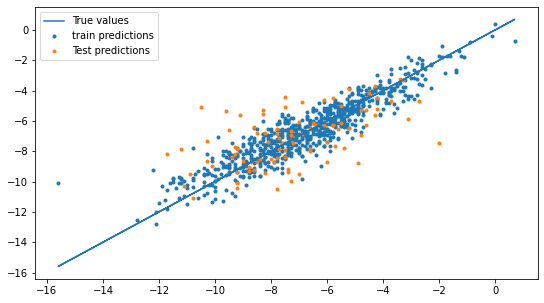

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.plot(train_plot_dataset, train_plot_dataset, label='True values')
plt.scatter(train_plot_dataset, train_preds, marker='.', label='train predictions')
plt.scatter(test_plot_dataset, test_preds, marker='.', label='Test predictions')

plt.legend()

# MDR1

In [149]:
train_dataset, valid_dataset, test_dataset, transformer = data_for_receptor(df, 'MDR1', seed=1)

In [136]:
model = GraphConvModel(n_tasks=tasks, batch_size=batch_size, mode='regression', number_atom_features=n_feat, learning_rate=learning_rate)
callback = dc.models.ValidationCallback(dataset=valid_dataset, interval=100, metrics=metrics, transformers=[transformer])
model.fit(train_dataset, nb_epoch=75, callbacks=callback)

Step 100 validation: rms_score=2.47178 mean_absolute_error=1.9231
Step 200 validation: rms_score=2.20011 mean_absolute_error=1.70805
Step 300 validation: rms_score=2.08757 mean_absolute_error=1.55983
Step 400 validation: rms_score=2.00353 mean_absolute_error=1.54961
Step 500 validation: rms_score=1.92206 mean_absolute_error=1.54224
Step 600 validation: rms_score=1.84829 mean_absolute_error=1.48019
Step 700 validation: rms_score=1.83825 mean_absolute_error=1.47607
Step 800 validation: rms_score=1.78291 mean_absolute_error=1.41699
Step 900 validation: rms_score=1.78151 mean_absolute_error=1.39461
Step 1000 validation: rms_score=1.77766 mean_absolute_error=1.39745
Step 1100 validation: rms_score=1.7316 mean_absolute_error=1.35287
Step 1200 validation: rms_score=1.73443 mean_absolute_error=1.3331
Step 1300 validation: rms_score=1.7334 mean_absolute_error=1.33812
Step 1400 validation: rms_score=1.69617 mean_absolute_error=1.30911
Step 1500 validation: rms_score=1.67871 mean_absolute_error=1

0.27875694274902346

In [139]:
print("Evaluating model")
train_scores = model.evaluate(train_dataset, metrics, [transformer])
valid_scores = model.evaluate(valid_dataset, metrics, [transformer])
test_scores = model.evaluate(test_dataset, metrics, [transformer])

print("Train scores")
print(train_scores, "\n")

print("Validation scores")
print(valid_scores, "\n")

print("test scores")
print(test_scores, "\n")

Evaluating model
Train scores
{'rms_score': 0.8484559517736948, 'mean_absolute_error': 0.6292968675291181} 

Validation scores
{'rms_score': 1.6514642199264757, 'mean_absolute_error': 1.2724061406177023} 

test scores
{'rms_score': 1.8713831931163953, 'mean_absolute_error': 1.3839440076247504} 



In [140]:
train_preds = transformer.untransform(model.predict(train_dataset))
test_preds = transformer.untransform(model.predict(test_dataset))
train_plot_dataset = transformer.untransform(train_dataset.y)
test_plot_dataset = transformer.untransform(test_dataset.y)

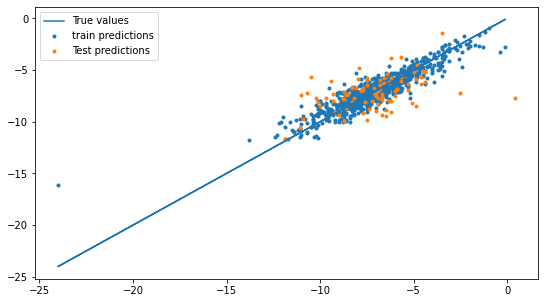

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.plot(train_plot_dataset, train_plot_dataset, label='True values')
plt.scatter(train_plot_dataset, train_preds, marker='.', label='train predictions')
plt.scatter(test_plot_dataset, test_preds, marker='.', label='Test predictions')


plt.legend()

# MRP8

In [157]:
train_dataset, valid_dataset, test_dataset, transformer = data_for_receptor(df, 'MRP8', seed=1)

In [158]:
model = GraphConvModel(n_tasks=tasks, batch_size=batch_size, mode='regression', number_atom_features=n_feat, learning_rate=learning_rate)
callback = dc.models.ValidationCallback(dataset=valid_dataset, interval=100, metrics=metrics, transformers=[transformer])
model.fit(train_dataset, nb_epoch=50, callbacks=callback)

Step 100 validation: rms_score=2.1837 mean_absolute_error=1.67219
Step 200 validation: rms_score=2.09585 mean_absolute_error=1.56002
Step 300 validation: rms_score=1.9162 mean_absolute_error=1.3733
Step 400 validation: rms_score=1.78714 mean_absolute_error=1.29926
Step 500 validation: rms_score=1.76486 mean_absolute_error=1.25343
Step 600 validation: rms_score=1.73957 mean_absolute_error=1.25677
Step 700 validation: rms_score=1.71627 mean_absolute_error=1.25173
Step 800 validation: rms_score=1.72861 mean_absolute_error=1.22593
Step 900 validation: rms_score=1.70905 mean_absolute_error=1.21143
Step 1000 validation: rms_score=1.73824 mean_absolute_error=1.2232
Step 1100 validation: rms_score=1.73665 mean_absolute_error=1.22432
Step 1200 validation: rms_score=1.75792 mean_absolute_error=1.23674


0.3930514907836914

In [159]:
print("Evaluating model")
train_scores = model.evaluate(train_dataset, metrics, [transformer])
valid_scores = model.evaluate(valid_dataset, metrics, [transformer])
test_scores = model.evaluate(test_dataset, metrics, [transformer])

print("Train scores")
print(train_scores, "\n")

print("Validation scores")
print(valid_scores, "\n")

print("Test scores")
print(test_scores, "\n")

Evaluating model
Train scores
{'rms_score': 0.9272240319316517, 'mean_absolute_error': 0.6478189758716091} 

Validation scores
{'rms_score': 1.757922778837715, 'mean_absolute_error': 1.2367418140493414} 

Test scores
{'rms_score': 1.6723099153114467, 'mean_absolute_error': 1.365366083003105} 



In [160]:
train_preds = transformer.untransform(model.predict(train_dataset))
test_preds = transformer.untransform(model.predict(test_dataset))
train_plot_dataset = transformer.untransform(train_dataset.y)
test_plot_dataset = transformer.untransform(test_dataset.y)

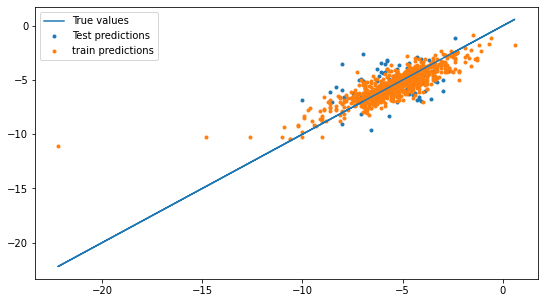

In [161]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.plot(train_plot_dataset, train_plot_dataset, label='True values')
plt.scatter(test_plot_dataset, test_preds, marker='.', label='Test predictions')
plt.scatter(train_plot_dataset, train_preds, marker='.', label='train predictions')

plt.legend()

# Hyperparameter Optimization

## Grid search

In [162]:
optimizer = dc.hyper.GridHyperparamOpt(dc.models.GraphConvModel)

params_dict = {
    'n_tasks': [1],
    'batch_size': [8, 256],
    'number_atom_features': [10, 160],
    'learning_rate': [0.1, 0.0001],
    'mode': ['regression']
}

In [163]:
best_model, best_hyperparams, all_results = optimizer.hyperparam_search(
    params_dict=params_dict,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    metric=metric,
    output_transformers=[transformer],
    use_max=False,
    nb_epoch=30,
)

In [164]:
best_hyperparams

{'n_tasks': 1,
 'batch_size': 8,
 'number_atom_features': 160,
 'learning_rate': 0.0001,
 'mode': 'regression'}

In [165]:
all_results

{'_batch_size_8_learning_rate_0.100000_moderegression_n_tasks_1_number_atom_features_10': 2.4866660270537393,
 '_batch_size_8_learning_rate_0.000100_moderegression_n_tasks_1_number_atom_features_10': 1.6833582218196912,
 '_batch_size_8_learning_rate_0.100000_moderegression_n_tasks_1_number_atom_features_160': 2.2472222355389633,
 '_batch_size_8_learning_rate_0.000100_moderegression_n_tasks_1_number_atom_features_160': 1.6044636024139622,
 '_batch_size_256_learning_rate_0.100000_moderegression_n_tasks_1_number_atom_features_10': 3.7965553075128695,
 '_batch_size_256_learning_rate_0.000100_moderegression_n_tasks_1_number_atom_features_10': 1.9183336399059452,
 '_batch_size_256_learning_rate_0.100000_moderegression_n_tasks_1_number_atom_features_160': 8.514329877622643,
 '_batch_size_256_learning_rate_0.000100_moderegression_n_tasks_1_number_atom_features_160': 1.9114930559967507}

## Gaussian Process

Example of how to use the Gaussian Process Hyperparameter optimization feature in DeepChem.

https://github.com/gitconnoisseur/toxicity-model/blob/9d04e1d234e87bc2402bdd7b4c9c1a88d9633c36/graph_conv.ipynb

In [ ]:
def model_builder(**model_params):
    return GraphConvModel(n_tasks=tasks, batch_size=batch_size, mode='regression')

optimizer = dc.hyper.GaussianProcessHyperparamOpt(model_builder=model_builder, max_iter=60)

params_dict = {
    "number_atom_features": 50,
    "learning_rate": 0.01,
}

best_model, best_hyperparams, all_results = optimizer.hyperparam_search(
    params_dict=params_dict,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    output_transformers=[transformer],
    metric=metric,
    use_max=False,
    nb_epoch=10,
)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.40000000e+01 2.82461192e-02]. 	  -1.9818126328442034 	 -1.8754202545208645
init   	 [18.          0.02829499]. 	  -1.8754202545208645 	 -1.8754202545208645
init   	 [4.40000000e+01 3.96950972e-03]. 	  -1.9530041570956145 	 -1.8754202545208645
1      	 [1.97000000e+02 1.71726762e-02]. 	  -1.8398955698200414 	 -1.8398955698200414
2      	 [1.52000000e+02 2.38244096e-02]. 	  -2.1588927720564164 	 -1.8398955698200414
3      	 [1.00000000e+02 9.04321692e-03]. 	  -1.9188163928664057 	 -1.8398955698200414
4      	 [1.24000000e+02 3.02442508e-02]. 	  -2.1842234220394037 	 -1.8398955698200414
5      	 [1.7300000e+02 2.9755538e-02]. 	  -1.885075640180661 	 -1.8398955698200414
6      	 [8.20000000e+01 1.17732139e-02]. 	  -2.087153859360262 	 -1.8398955698200414
7      	 [3.10000000e+01 1.00789605e-02]. 	  -1.9372399224663746 	 -1.8398955698200414
8      	 [1.38000000e+02 3.43946956e-02]. 	  -2.0383776151084283 	 -1.839895569820